Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)


Load dataset

In [2]:
fraud = pd.read_csv("../data/raw/Fraud_Data.csv")
ip_country = pd.read_csv("../data/raw/IpAddress_to_Country.csv")


Initial inspection

In [3]:
fraud.head()
fraud.info()
fraud.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB


,user_id,purchase_value,age,ip_address,class
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


# Data Cleaning

In [4]:
fraud.isnull().sum()


user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64

In [5]:
fraud['age'].fillna(fraud['age'].median(), inplace=True)


Remove duplicates

In [6]:
fraud.duplicated().sum()
fraud.drop_duplicates(inplace=True)


Fix data types


In [7]:
fraud['signup_time'] = pd.to_datetime(fraud['signup_time'])
fraud['purchase_time'] = pd.to_datetime(fraud['purchase_time'])


Class imbalance

In [8]:
fraud['class'].value_counts(normalize=True) * 100


class
0    90.635423
1     9.364577
Name: proportion, dtype: float64

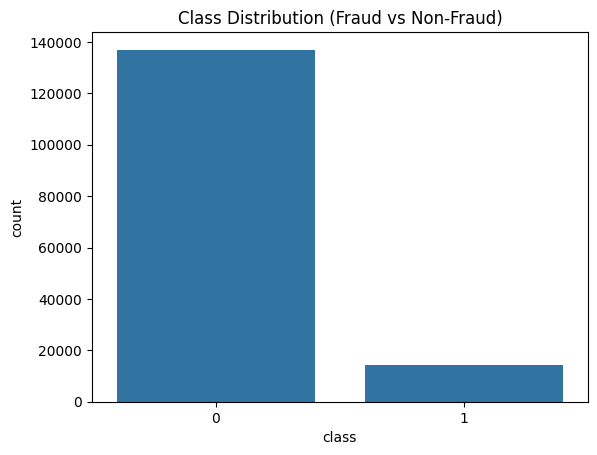

In [9]:
sns.countplot(x='class', data=fraud)
plt.title("Class Distribution (Fraud vs Non-Fraud)")
plt.show()


Univariate analysis

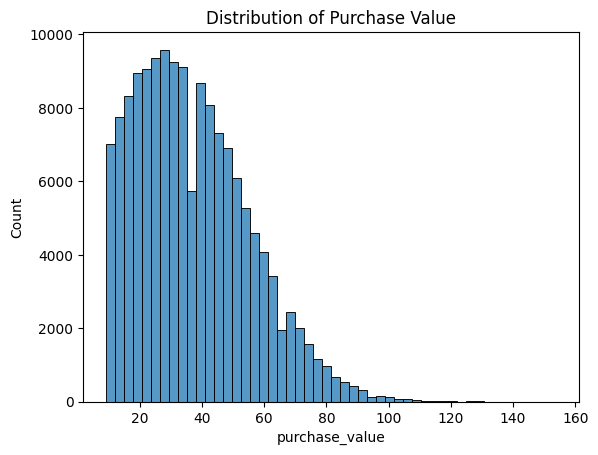

In [10]:
sns.histplot(fraud['purchase_value'], bins=50)
plt.title("Distribution of Purchase Value")
plt.show()


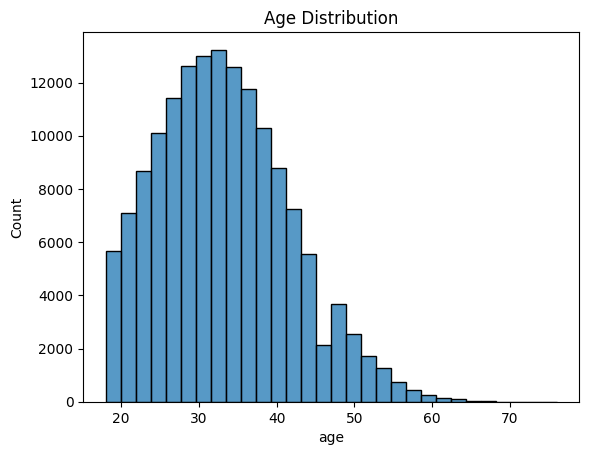

In [11]:
sns.histplot(fraud['age'], bins=30)
plt.title("Age Distribution")
plt.show()


Bivariate analysis

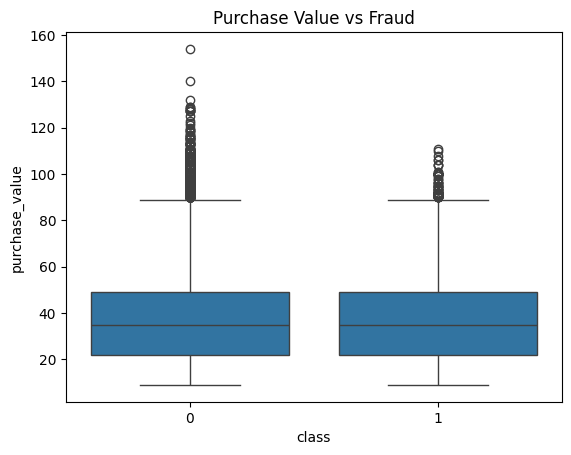

In [12]:
sns.boxplot(x='class', y='purchase_value', data=fraud)
plt.title("Purchase Value vs Fraud")
plt.show()


Geolocation Integration (IMPORTANT & SCORED)

Convert IP address to integer

In [13]:
fraud['ip_address'] = fraud['ip_address'].astype(np.int64)


Prepare IP country data

In [14]:
ip_country['lower_bound_ip_address'] = ip_country['lower_bound_ip_address'].astype(np.int64)
ip_country['upper_bound_ip_address'] = ip_country['upper_bound_ip_address'].astype(np.int64)


Merge using range-based lookup

In [15]:
ip_country_sorted = ip_country.sort_values('lower_bound_ip_address')

fraud_sorted = fraud.sort_values('ip_address')

fraud_geo = pd.merge_asof(
    fraud_sorted,
    ip_country_sorted,
    left_on='ip_address',
    right_on='lower_bound_ip_address',
    direction='backward'
)

fraud_geo = fraud_geo[
    fraud_geo['ip_address'] <= fraud_geo['upper_bound_ip_address']
]


Fraud by country

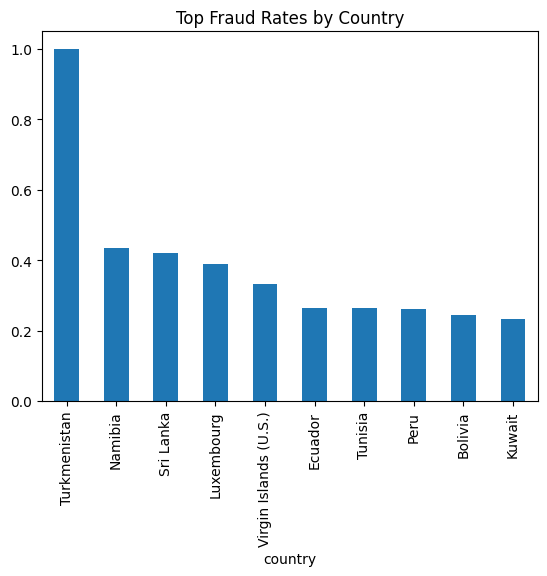

In [16]:
country_fraud = fraud_geo.groupby('country')['class'].mean().sort_values(ascending=False).head(10)
country_fraud.plot(kind='bar')
plt.title("Top Fraud Rates by Country")
plt.show()
